# Coding practical: ODE - Gravitational 2-body problem

### General guidelines:
* Make sure to put your name in the body of the notebook, and in the filename.
* You may discuss these problems with other students in class, but you must turn in your own notebook.
* List anyone with whom you discussed the work.
* Please document your code, label your plots, and use markdown cells to add explanatory comments to the notebook.
* Save your notebook as a pdf file and submit it in Canvas before the deadline.

You may not distribute this notebook beyond our class, or post it anywhere online, without permission from the instructor.

### Specific instructions:
* Consider the gravitational interaction between two masses $M_1$ and $M_2$. To review the theory, see Chapter 4 of the textbook from Physics 341.
* Solve the relevant differential equations to compute the orbits for $M_1 = M_\odot$, $M_2 = 2 M_\odot$, $a = 1$ AU, and two geometries: a circular orbit, and an elliptical orbit with eccentricity $e = 0.5$. Plot the orbits. Check the conservation law(s) that should apply.
* Explain your choice of units.
* What happens if the initial conditions are not correct? Try messing up the initial conditions and see what you get. *Hint:* you may wind up with a situation in which the center of mass is not fixed.

In [1]:
# your code here

# Name: Harshil Patel

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from astropy import constants as const
from astropy import units as u
plt.rcParams.update({'font.size': 16})

## Gravitational 2-body problem

### Unit choice
The choice of units I picked was astro units: distances in AU, time in years, and masses in solar masses. In this case G is defined as $G = 4\pi^2$ AU$^3$ $M_\odot^{-1}$ yr$^{-2}$. I made this choice of units in order to simplify certain expressions, such as the expression for period, and for the sake of scale clarity in plots. 

### First order equations
The equations here are very similar to the 1-body case. For the one-body case, we know that

$$
  \frac{d^2{\vec r}}{dt^2} = -\frac{GM}{r^3} {\vec r}
$$

Since we are dealing with two bodies, we must consider the force of each mass on the other. Since the distance between the masses (r) is the same in both equations and the forces act in opposite directions, we have:

\begin{eqnarray}
    \frac{d^2{\vec r_1}}{dt^2} = \frac{GM_2}{r^3} {\vec r_1} &\qquad 
    \frac{d^2{\vec r_2}}{dt^2} = -\frac{GM_1}{r^3} {\vec r_2}
\end{eqnarray}

We can split each of these differential equations into six first-order ODEs, making a total of twelve first-order ODEs:

\begin{eqnarray}
  \frac{dx_1}{dt} = v_{x,1} &\qquad \frac{dv_{x,1}}{dt} = -\frac{GM\Delta x}{r^3} \\
  \frac{dy_1}{dt} = v_{y,1} &\qquad \frac{dv_{y,1}}{dt} = -\frac{GM\Delta y}{r^3} \\
  \frac{dz_1}{dt} = v_{z,1} &\qquad \frac{dv_{z,1}}{dt} = -\frac{GM\Delta z}{r^3}
\end{eqnarray}

\begin{eqnarray}
  \frac{dx_2}{dt} = v_{x,2} &\qquad \frac{dv_{x,2}}{dt} = -\frac{GM\Delta x}{r^3} \\
  \frac{dy_2}{dt} = v_{y,2} &\qquad \frac{dv_{y,2}}{dt} = -\frac{GM\Delta y}{r^3} \\
  \frac{dz_2}{dt} = v_{z,2} &\qquad \frac{dv_{z,2}}{dt} = -\frac{GM\Delta z}{r^3}
\end{eqnarray}

Where $\Delta x, \Delta y, \Delta z$ are all differences between the x, y, and z positions of the orbiting bodies, respectively.

### Momentum Conservation
We can check that angular momentum is conserved by using the following expression:

$$
    L = m_1\textbf{r}_1\times\textbf{v}_1 + m_2\textbf{r}_2\times\textbf{v}_2 
$$

The check_cons method will make this check every time the set of ODEs is solved via solve_2body or custom_2body, based on the initial and final positions and velocities of the masses.

In [3]:
# 2 body vec = [x1, y1, z1, vx1, vy1, vz1, x2, y2, z2, vx2, vy2, vz2]
key_arr = ['x1', 'y1', 'z1', 'vx1', 'vy1', 'vz1', 'x2', 'y2', 'z2', 'vx2', 'vy2', 'vz2']

#Unit choice
Gast = 4.0*np.pi**2

class two_body(object):
    def __init__(self,m1,m2,a,e):
        self.M1 = m1
        self.M2 = m2
        self.a = a
        self.e = e
        self.get_inits()

    def df_2body_ast(self,vec,t):
        M1 = self.M1
        M2 = self.M2

        #2 body physical parameters
        x1 = vec[0]
        y1 = vec[1]
        z1 = vec[2]
        vx1 = vec[3]
        vy1 = vec[4]
        vz1 = vec[5]
        x2 = vec[6]
        y2 = vec[7]
        z2 = vec[8]
        vx2 = vec[9]
        vy2 = vec[10]
        vz2 = vec[11]

        #distance between them 
        r = np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)

        #Acceleration factors 
        GM1r3 = Gast*self.M2/r**3
        GM2r3 = -Gast*self.M1/r**3

        #net d2 vector
        dvec = np.zeros(12)
        dvec[0] = vx1
        dvec[1] = vy1
        dvec[2] = vz1
        dvec[3] = -GM1r3*(x1-x2)
        dvec[4] = -GM1r3*(y1-y2)
        dvec[5] = -GM1r3*(z1-z2)
        dvec[6] = vx2
        dvec[7] = vy2
        dvec[8] = vz2
        dvec[9] = -GM2r3*(x1-x2)
        dvec[10] = -GM2r3*(y1-y2)
        dvec[11] = -GM2r3*(z1-z2)
        return dvec
    
    
    #calculate initial vector quantities for ode
    def get_inits(self):
        #calculate necessary orbit properties
        M1,M2,a,e = self.M1,self.M2,self.a,self.e
        Mtot = M1+M2
        mu = (M1*M2)/(Mtot)
        
        #Calculate the period and initial velocities 
        P = (a**3/Mtot)**(1/2)
        
        #Find angular momentum for the one-body problem analogy 
        l = (Gast*Mtot*a*(1-e**2))**(1/2)
        r = a*(1-e**2)/(1+e) #phi is zero when both masses start at the x axis
        #calculate velocity for the separation vector
        v = l/r
        
        #calculate velocities for body
        self.v1 = -mu*v/M1
        self.v2 = mu*v/M2
        self.r = r
        self.P = P
        return
        
    #let system evolve for a time period of pval * P    
    def solve_2body(self,pval):        
        #vector with initial values
        vec0 = np.array([0,0,0,0,self.v1,0,self.r,0,0,0,self.v2,0])
        tarr = np.linspace(0,pval*self.P,1000)
        
        # solve the ODE
        ans = integrate.odeint(self.df_2body_ast,vec0,tarr) 
        
        # extract plotting variables
        self.x1 = ans[:,0]
        self.y1 = ans[:,1]
        self.x2 = ans[:,6]
        self.y2 = ans[:,7]
        
        #check conservation laws
        self.cons = self.check_cons(vec0.tolist())
        
        return vec0.tolist()
        
    #allow user to input incorrect initial values and let system evolve for a time period of 
    #pval * P
    def custom_2body(self,params,pval):
        M1,M2,a,e = self.M1,self.M2,self.a,self.e
        Mtot = M1+M2
        mu = (M1*M2)/(Mtot)
        P = (self.a**3/Mtot)**(1/2)
        x1,y1,z1,vx1,vy1,vz1,x2,y2,z2,vx2,vy2,vz2 = params
        
        #vector with initial values
        vec0 = np.array([x1,y1,z1,vx1,vy1,vz1,x2,y2,z2,vx2,vy2,vz2])
        tarr = np.linspace(0,pval*P,1000)
        
        # solve the ODE
        ans = integrate.odeint(self.df_2body_ast,vec0,tarr) 
        
        # extract plotting variables
        self.x1 = ans[:,0]
        self.y1 = ans[:,1]
        self.x2 = ans[:,6]
        self.y2 = ans[:,7]
        
        #check conservation laws
        self.cons = self.check_cons(vec0.tolist())
        
        return vec0.tolist()
    
    #check conservation
    def check_cons(self,s2):
        M1,M2 = self.M1,self.M2
        mu = (M1*M2)/(M1+M2)
        v1_0,v2_0,r_0 = self.v1,self.v2,self.r
            
        #initialize relevant vectors
        p1 = np.array([s2[0],s2[1],s2[2]])
        v1 = np.array([s2[3],s2[4],s2[5]])
        p2 = np.array([s2[6],s2[7],s2[8]])
        v2 = np.array([s2[9],s2[10],s2[11]])
        r = p2-p1
        r1 = -(mu/M1)*r #r1 vector
        r2 = (mu/M2)*r #r2 vector
        
        #calculate and compare initial angular momentum and final
        L0 = M1*0*v1_0+M2*r_0*v2_0
        L1 = M1*np.linalg.norm(np.cross(r1,v1))+M2*np.linalg.norm(np.cross(r2,v2))
        
        if(abs(L0-L1)/L0 <= 0.0000000005):
            return "Angular momentum conserved"
        else:
            return "Angular momentum not conserved"
        
    #Plot results
    def plots(self):
        plt.rcParams.update({'font.size': 16})
        plt.figure(figsize=(12,12))
        plt.title("2-Body Orbit, e = %.2f" % self.e)
        plt.plot(self.x1,self.y1,label = "$M_1$")
        plt.plot(self.x2,self.y2,label = "$M_2$")
        plt.xlabel('x (AU)')
        plt.ylabel('y (AU)')
        plt.legend()
        plt.gca().set_aspect('equal')
        plt.show()
        print(self.cons)

### Initial Conditions
In order for the orbits to work, proper initial conditions need to be set. The initial position was set such that the first body was located at (0,0), and the second body was located a distance of r away from the first body at (0,r). To calculate the distance, we use the solution to the one-body problem and eq. 4.11 in the (Keeton, 2014): 

$$
    r = \frac{a\:(1-e^2)}{1+e\text{ cos }\phi}
$$

Since both initial positions are on the x axis, $\phi = 0$ and cos $\phi = 1$, so the denominator simply becomes (1+e). To calculate initial velocities, we can find the time derivative of the separation vector by using angular momentum. From eqs. 3.11 and 3.6 we have the specific angular momentum, and substituting G = 4$\pi^2$ we get:

$$
    l = |\textbf{r} \times \textbf{v}| = [4\pi^2 Ma(1-e^2)]^{1/2}
$$

Since r and v are perpendicular for our initial conditions, we can solve for the velocity v:

$$
    l = rv = [4\pi^2 Ma(1-e^2)]^{1/2} \\
    v = \frac{[4\pi^2 Ma(1-e^2)]^{1/2}}{r}
$$

Applying eq. 4.13 and reduced mass $\mu = m_1 m_2\:/\:(m_1+m_2)$, we can get initial velocities for each body:

\begin{eqnarray}
    v_1 = -\frac{\mu}{m_1} v &\qquad 
    v_2 = \frac{\mu}{m_2} v
\end{eqnarray}

To calculate the period, we use Kepler's third law and solve for P: 

$$
    P = \sqrt{\frac{4\pi^2 a^3}{GM}} = \sqrt{\frac{a^3}{M}}
$$

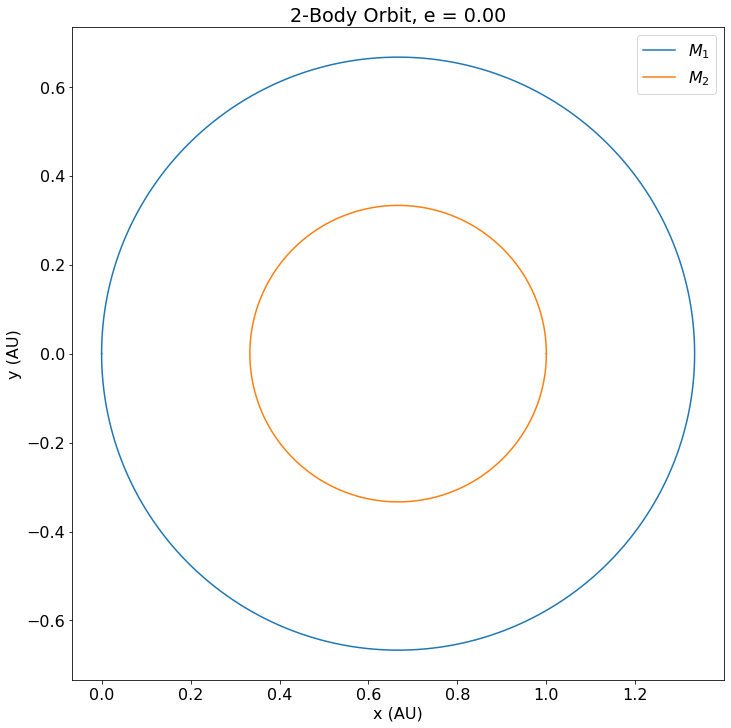

Angular momentum conserved


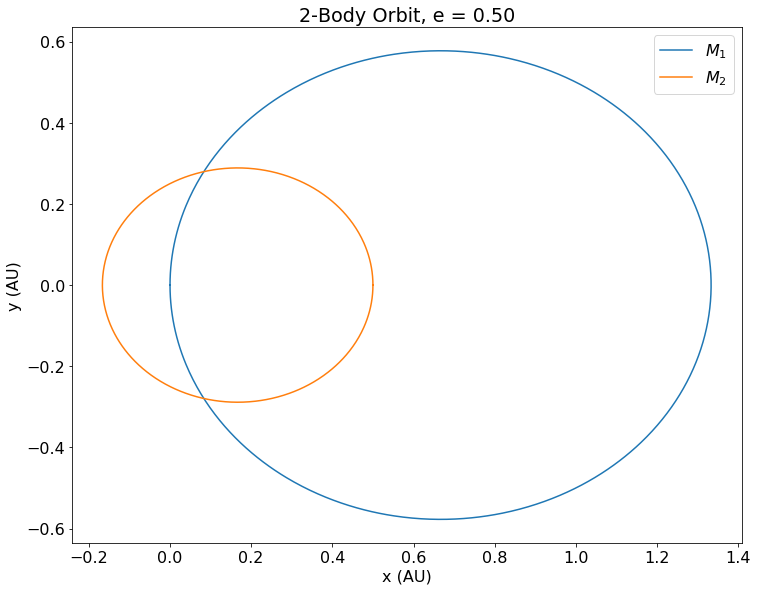

Angular momentum conserved

System 2 After 1 period
x1:	0.00000
y1:	0.00000
z1:	0.00000
vx1:	0.00000
vy1:	-12.56637
vz1:	0.00000
x2:	0.50000
y2:	0.00000
z2:	0.00000
vx2:	0.00000
vy2:	6.28319
vz2:	0.00000


In [7]:
system1 = two_body(1,2,1,0)
system1.solve_2body(1)
system1.plots()


system2 = two_body(1,2,1,0.5)
vec = system2.solve_2body(1)
system2.plots()
print("\nSystem 2 After 1 period")
for i in range(0,len(vec)):
    print("%s:\t%.5f" % (key_arr[i],vec[i]))

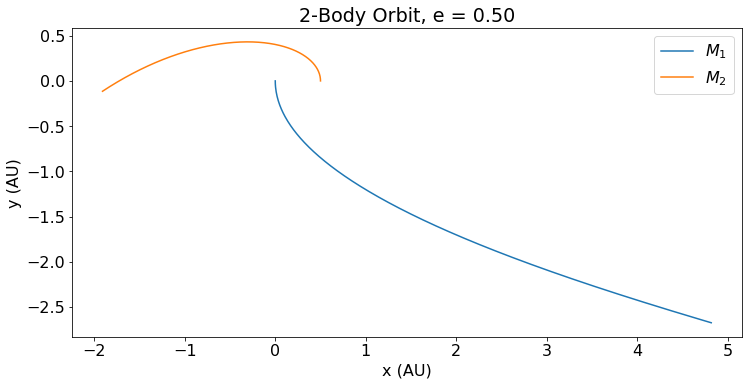

Angular momentum not conserved


In [248]:
#Using incorrect initial conditions for the e=0.5 system

#increasing M1's speed by 20%
vec2 = vec.copy()
vec2[4]*=1.2
system3 = two_body(1,2,1,0.5)
system3.custom_2body(vec2,2)
system3.plots()

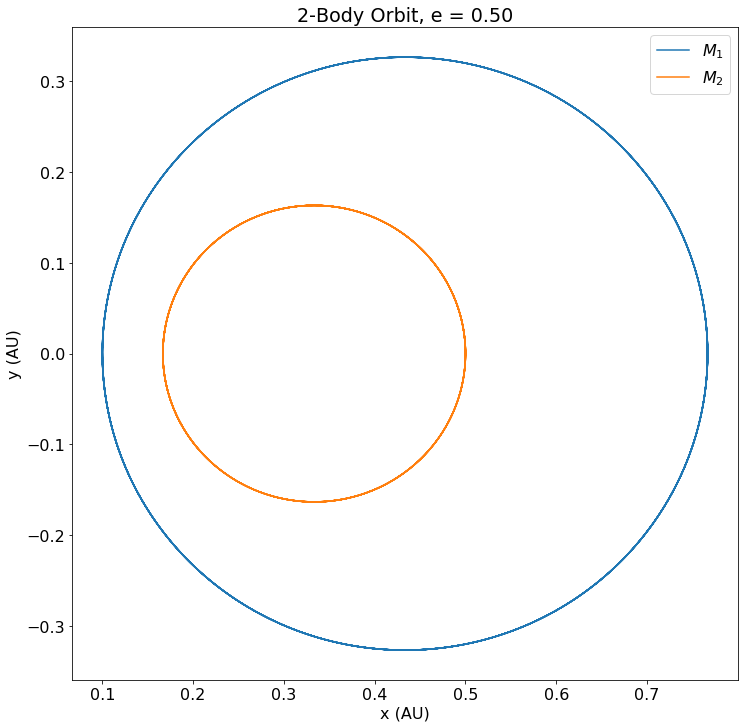

Angular momentum not conserved


In [250]:
#shifting M1 to the right by 0.1 AU
vec2 = vec.copy()
vec2[0]+=0.1
system2.custom_2body(vec2,2)
system2.plots()


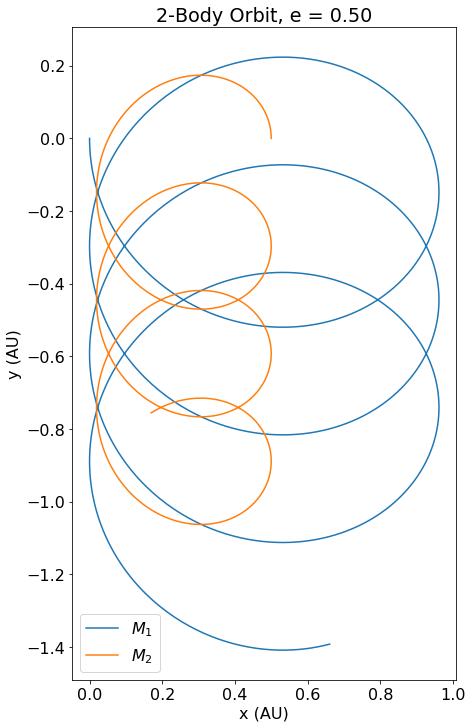

Angular momentum not conserved


In [251]:
#decreasing M2's velocity by 20% 
vec2 = vec.copy()
vec2[10]*=0.8
system2.custom_2body(vec2,2)
system2.plots()

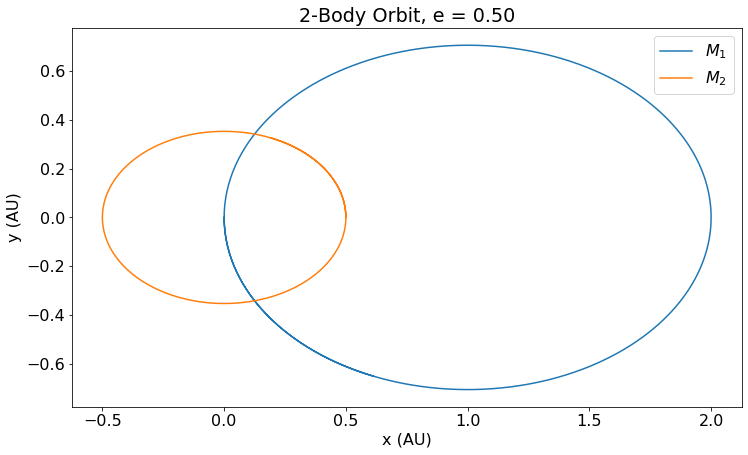

Angular momentum not conserved


In [252]:
#adding another velocity component to M2 
vec2 = vec.copy()
vec2[11]=vec2[10]
system2.custom_2body(vec2,2)
system2.plots()

In [103]:
# 2 body vec = [x1, y1, z1, vx1, vy1, vz1, x2, y2, z2, vx2, vy2, vz2]
key_arr = ['x1', 'y1', 'z1', 'vx1', 'vy1', 'vz1', 'x2', 'y2', 'z2', 'vx2', 'vy2', 'vz2']

#Unit choice
Gast = 4.0*np.pi**2
pi = np.pi

class three_body(object):
    def __init__(self,m1,m2,m3,a,a3):
        self.M1 = m1
        self.M2 = m2
        self.M3 = m3
        self.a = a
        self.a3 = a3
        self.get_inits()

    def df_3body_ast(self,vec,t):
        M1 = self.M1
        M2 = self.M2
        M3 = self.M3

        #3 body physical parameters
        x1,y1,z1 = vec[0],vec[1],vec[2]
        vx1,vy1,vz1 = vec[3],vec[4],vec[5]
        
        x2,y2,z2 = vec[6],vec[7],vec[8]
        vx2,vy2,vz2 = vec[9],vec[10],vec[11]
        
        x3,y3,z3 = vec[12],vec[13],vec[14]
        vx3,vy3,vz3 = vec[15],vec[16],vec[17]
        
        #separation between each two bodies
        dx12, dy12, dz12 = x2-x1, y2-y1, z2-z1
        dx13, dy13, dz13 = x3-x1, y3-y1, z3-z1
        dx23, dy23, dz23 = x3-x2, y3-y2, z3-z2

        d12 = np.sqrt(dx12**2+dy12**2+dz12**2)
        d13 = np.sqrt(dx13**2+dy13**2+dz13**2)
        d23 = np.sqrt(dx23**2+dy23**2+dz23**2)

        #Acceleration factors 
        GM1 = Gast*self.M1
        GM2 = Gast*self.M2
        GM3 = Gast*self.M3
        
        ax1 = (GM2/d12**3)*dx12 + (GM3/d13**3)*dx13
        ay1 = (GM2/d12**3)*dy12 + (GM3/d13**3)*dy13
        az1 = (GM2/d12**3)*dz12 + (GM3/d13**3)*dz13
        ax2 = -(GM1/d12**3)*dx12 + (GM3/d23**3)*dx23
        ay2 = -(GM1/d12**3)*dy12 + (GM3/d23**3)*dy23
        az2 = -(GM1/d12**3)*dz12 + (GM3/d23**3)*dz23
        ax3 = -(GM1/d13**3)*dx13 - (GM2/d23**3)*dx23
        ay3 = -(GM1/d13**3)*dy13 - (GM2/d23**3)*dy23
        az3 = -(GM1/d13**3)*dz13 - (GM2/d23**3)*dz23

        #net d3 vector
        dvec = np.zeros(18)
        dvec[0], dvec[1], dvec[2] = vx1, vy1, vz1
        dvec[3], dvec[4], dvec[5] = ax1, ay1, az1

        dvec[6], dvec[7], dvec[8] = vx2, vy2, vz2
        dvec[9], dvec[10], dvec[11] = ax2, ay2, az2

        dvec[12], dvec[13], dvec[14] = vx3, vy3, vz3
        dvec[15], dvec[16], dvec[17] = ax3, ay3, az3
        return dvec
    
    
    #calculate initial vector quantities for ode
    def get_inits(self):
        #calculate necessary orbit properties
        M1,M2,M3,a,a3 = self.M1,self.M2,self.M3,self.a,self.a3
        Mtot = M1+M2
        mu = (M1*M2)/(Mtot)
        
        self.r1 = -a*(mu/M1)
        self.r2 = a*(mu/M2)
        self.r3 = a3
    
        #Find angular momentum for the one-body problem analogy 
        #l = (Gast*Mtot*a)**(1/2)
        #l3 = (Gast*Mtot*a3)**(1/2)
        #r = a #phi is zero when both masses start at the x axis
        #calculate velocity for the separation vector
        #v = l/r
        
        #Calculate the period and initial velocities 
        self.P = (a**3/Mtot)**(1/2)
        self.P3 = (a3**3/Mtot)**(1/2)
        
        #calculate velocities for body
        self.v1 = 2*pi*self.r1/self.P
        self.v2 = 2*pi*self.r2/self.P
        self.v3 = 2*pi*self.r3/self.P3
        
        rarr = np.array([[self.r1,0,0],[self.r2,0,0],[self.r3,0,0]])
        varr = np.array([[0,self.v1,0],[0,self.v2,0],[0,self.v3,0]])
        marr = np.array([M1,M2,M3])
        
        #center of mass position and velocity
        rcom = np.dot(np.array(rarr),np.array(marr))/np.sum(marr)
        vcom = np.dot(marr,varr)/np.sum(marr)
        
        self.rarr = rarr-rcom
        self.varr = varr-vcom

        return
        
    #let system evolve for a time period of pval * P    
    def solve_3body(self,pval):        
        #vector with initial values
        rarr,varr = self.rarr,self.varr
        #print(rarr)
        #print(varr)
        
        vec0 = np.array([])
        for i in range(0,3):
            vec1 = np.concatenate([rarr[i],varr[i]],axis = 0)
            vec0 = np.concatenate([vec0,vec1],axis = 0)
        #print(vec0)
        tarr = np.linspace(0,pval*self.P3,300)
        
        # solve the ODE
        ans = integrate.odeint(self.df_3body_ast,vec0,tarr) 
        
        # extract plotting variables
        self.x1, self.y1, self.z1 = ans[:,0], ans[:,1], ans[:,2]
        self.x2, self.y2, self.z2 = ans[:,6], ans[:,7], ans[:,8]
        self.x3, self.y3, self.z3 = ans[:,12], ans[:,13], ans[:,14]
        
        #check conservation laws
        
        return self.x1,self.y1,self.x2,self.y2,self.x3,self.y3,tarr
        
    #Plot results
    def plots(self):
        plt.rcParams.update({'font.size': 16})
        plt.figure(figsize=(12,12))
        plt.title("3-Body Orbit")
        plt.plot(self.x1,self.y1,label = "$M_1$")
        plt.plot(self.x2,self.y2,label = "$M_2$")
        plt.plot(self.x3,self.y3,label = "$M_3$")
        plt.xlabel('x (AU)')
        plt.ylabel('y (AU)')
        plt.legend()
        plt.gca().set_aspect('equal')
        plt.show()
        #print(self.cons)

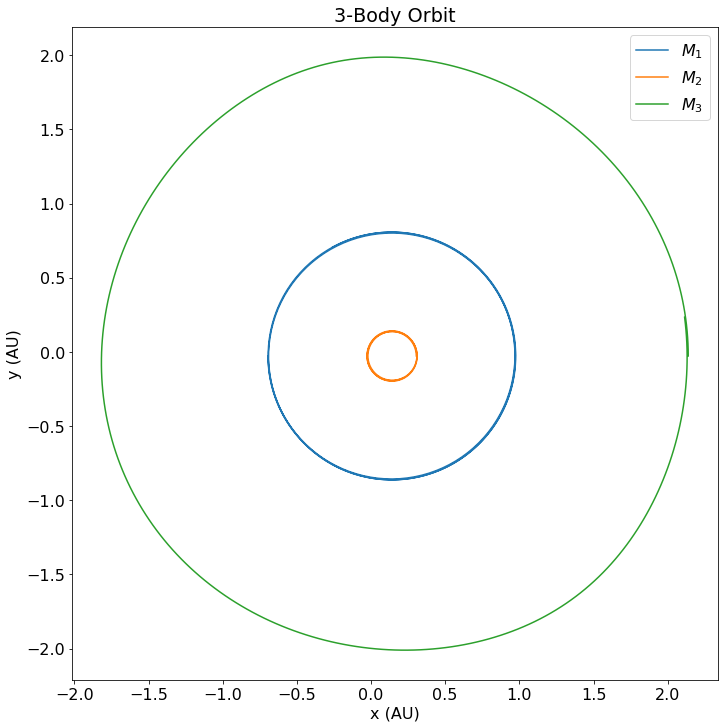

In [105]:
from astropy import units as u
Mjup = (u.Mjup/u.Msun)
#initial conditions, starting with 2 sun types and planet

#Initialization parameters: M1, M2, M3, a1, a2 (in solar masses and AU)
system1 = three_body(1,5,10*Mjup,1,2)

#ODE solver parameters: orbital periods (number of periods to let the system evolve)
system1.solve_3body(1)

#Plot results
system1.plots()

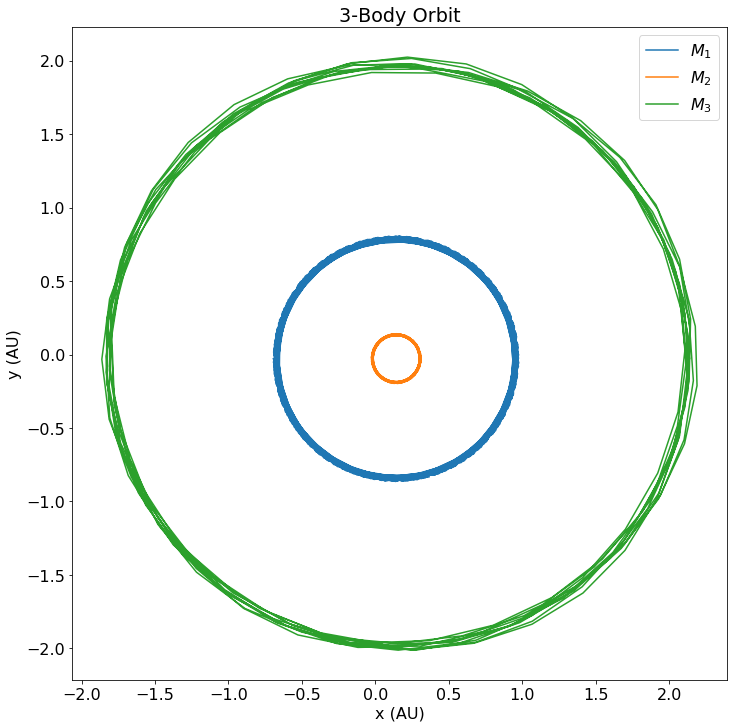

In [106]:
system1.solve_3body(10)
system1.plots()

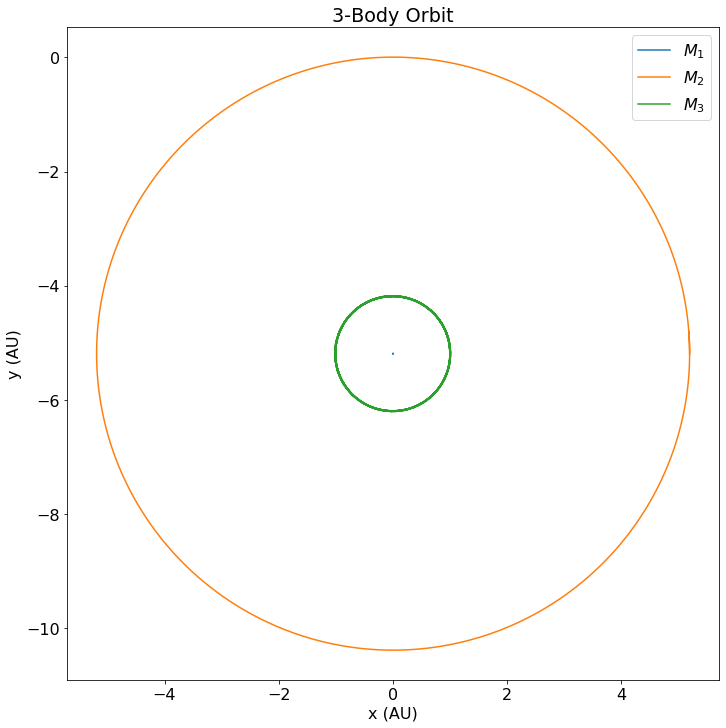

In [111]:
#initial conditions, sun jupiter earth

Mearth = (u.Mearth/u.Msun)
system1 = three_body(1,1*Mjup,1*Mearth,5.2,1)
system1.solve_3body(12)
system1.plots()

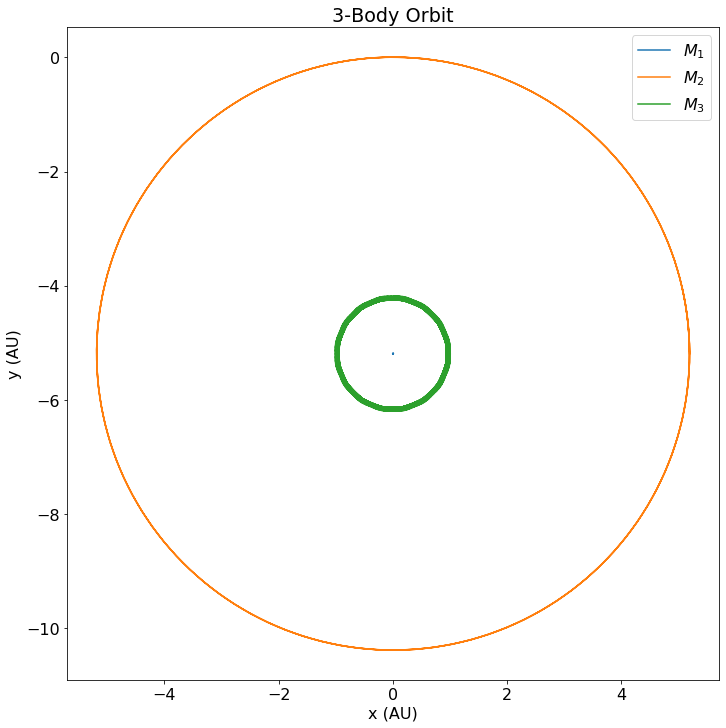

In [112]:
#3 orbits
system1.solve_3body(36)
system1.plots()

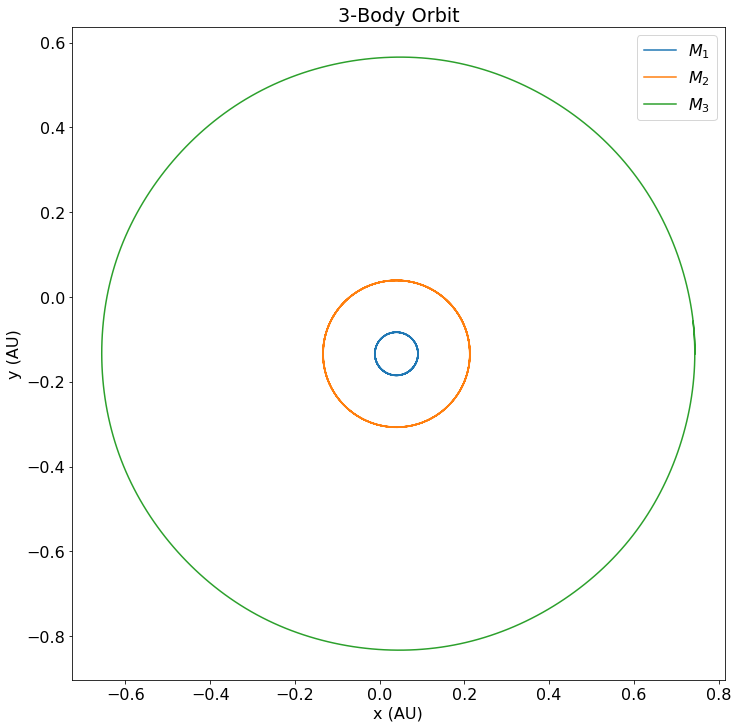

In [113]:
#using the known conditions of the Kepler-16 system to check

Mearth = (u.Mearth/u.Msun)
system2 = three_body(0.6897,0.20255,0.333*Mjup,.22431,.7048)
system2.solve_3body(1)
system2.plots()

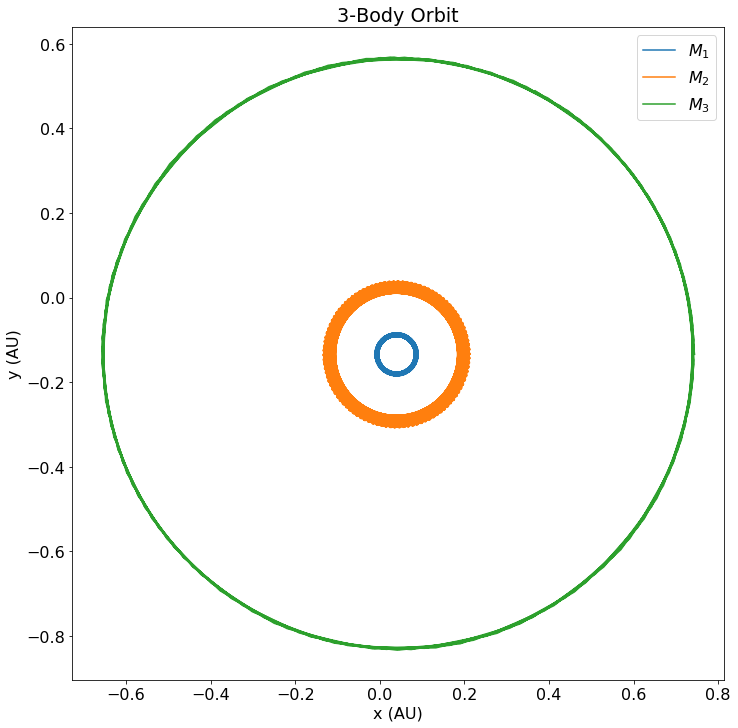

In [116]:
#after 10 planetary revolutions
x1,y1,x2,y2,x3,y3,tarr = system2.solve_3body(10)
system2.plots()

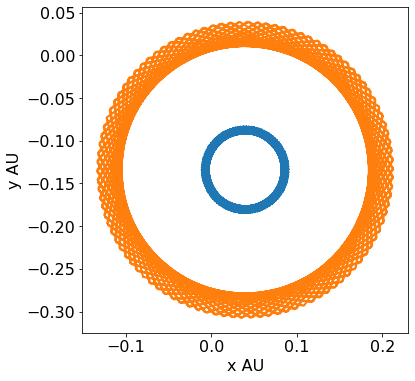

In [117]:
#close up of the binary stars after 10 planetary revolutions

plt.figure(figsize=(6,6))
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.xlabel('x AU')
plt.ylabel('y AU')
#plt.title('Circular Orbit')
plt.gca().set_aspect('equal')
plt.show()

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


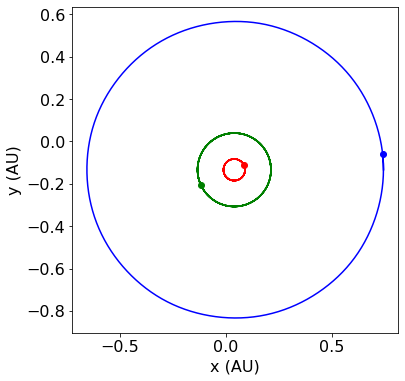

In [118]:
from celluloid import Camera

#Create movie for Kepler-16 orbit
x1,y1,x2,y2,x3,y3,tarr = system2.solve_3body(1)

# set up the plot
fig = plt.figure(figsize=(6,6))
camera = Camera(fig)

# specify axis limits and labels
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
plt.gca().set_aspect('equal')

# loop over times, and take a "snapshot" at each time
for tindx in range(len(tarr)):
    plt.plot(x1[tindx],y1[tindx],'o',color='r')
    plt.plot(x2[tindx],y2[tindx],'o',color='g')
    plt.plot(x3[tindx],y3[tindx],'o',color='b')
    # add the orbits
    plt.plot(x1[:tindx+1],y1[:tindx+1],color='r')
    plt.plot(x2[:tindx+1],y2[:tindx+1],color='g')
    plt.plot(x3[:tindx+1],y3[:tindx+1],color='b')
    #plt.plot(0,0,'*',color='black')
    camera.snap()

# save the results
camera.animate().save('kepler16.gif',fps=10,dpi=300)